In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import folium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform

In [3]:
df = pd.read_json("./data/norge.geojson")
fylker = df["administrative_enheter.fylke"]["features"]

gdf = gpd.GeoDataFrame.from_features(fylker)

In [4]:
for fylke in fylker:
    print(fylke["properties"]["fylkesnummer"] + " - " + fylke["properties"]["navn"][0]["navn"])

42 - Agder
03 - Oslo
54 - Troms og Finnmark
15 - Møre og Romsdal
38 - Vestfold og Telemark
50 - Trøndelag
11 - Rogaland
34 - Innlandet
30 - Viken
18 - Nordland
46 - Vestland


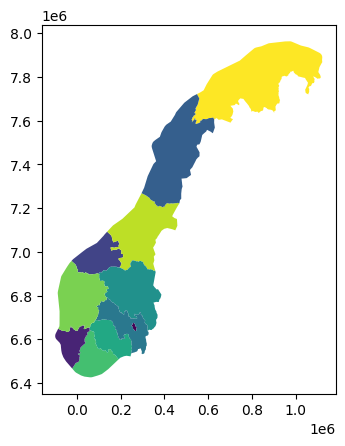

In [5]:
gdf.plot(column='fylkesnummer', cmap='viridis')
FYLKESNUMMER_INDEX = [42, 3, 54, 15, 38, 50, 11, 34, 30, 18, 46]

In [6]:
df_locations = pd.read_json("./data/locations.json")
df_locations.describe

<bound method NDFrame.describe of             lat        lng
0     61.908325   8.163896
1     62.040253   9.153127
2     66.178825  12.492315
3     58.349545   7.963340
4     61.177292   8.696439
...         ...        ...
3738  59.734043  10.587370
3739  68.786591  16.121395
3740  70.205780  23.206917
3741  69.482941  18.861254
3742  66.051880  13.648970

[3743 rows x 2 columns]>

In [7]:
df_locations['fylkesnummer'] = [None]*df_locations['lat'].size

In [9]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:25833')

for index in df_locations.index:
    point = Point(transform(inProj,outProj, df_locations['lng'][index], df_locations['lat'][index]))
    for i in gdf.index:
        polygon = gdf['geometry'][i]
        if polygon.contains(point):
            df_locations['fylkesnummer'][index] = FYLKESNUMMER_INDEX.index(int(gdf['fylkesnummer'][i]))

c:\Users\sande\Desktop\repos\norwai\env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\sande\Desktop\repos\norwai\env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\sande\AppData\Local\Temp\ipykernel_9424\3088903204.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pypr

In [10]:
df_locations.to_json('data/locations_county.json', orient='records')

In [12]:
viridis = cm.get_cmap('viridis', 12)
cmap = viridis(range(11))

m = folium.Map((64.9701, 13.509217), zoom_start=4)
for i in df_locations.index:
    if df_locations['fylkesnummer'][i] == None:
        continue
    color = colors.rgb2hex(cmap[df_locations['fylkesnummer'][i]])
    folium.CircleMarker(location=(df_locations['lat'][i], df_locations['lng'][i]), radius=1, color=color,
                     fill_color=color, ).add_to(m)
m